In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import json
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers


In [3]:
# ********************     HANDLE CLASS IMBALANCE    ********************************


# : CLASS imbalance means ROI (stenosis) is very small as
# compared to BG. so, ROI k pixels k weights increase kryn gy and we will use 2 approches: weighted catagory
# crossentropy and DICE loss.

# 1️⃣ Weighted Categorical Crossentropy (WCE)

def weighted_categorical_crossentropy(y_true, y_pred):
    class_weights = [1, 10]
    weights = tf.constant(class_weights, dtype=tf.float32)  # Convert to tensor because lists are
                                                            # not suitable for complex operations

    # Use tf.keras.backend.clip instead of K.clip
    y_pred = tf.keras.backend.clip(y_pred, 1e-6, 1 - 1e-6)  # Prevent log(0) issue, model jab predict kry ga
    # k class 1 h ya class 0 h, to vo probablity btay ga hr class ki, possible h k vo kisi class ki
    # probability 0 btay and kisi ki 1 btay, to jab loss calculate krty huy hm log len gy to log(0) pr
    # value infinity ati h, is liye hm probablity ki range ko chnage krty hn yani 1e-7 yani almost 0 and
    # 1-1e-7 almost 1, not equal to 0 and not equal to 1

    loss = -tf.keras.backend.sum(y_true * tf.keras.backend.log(y_pred) * weights, axis=-1)  # is pixel pr asal
    # m thi class 1 (ROI) means like this : [0 1], jo bhi model n predict kia
    # yani e.g class 0 ki probablity 0.9 predict ki (yani 0.9 chnaces hn k is pixel m class 0 h) and class 1 ki
    #  probablity 0.1 predict ki yani: [0.9, 0.1], to hm n in values k log le liye
    #   yani:  [log(0.9), log(0.1)] ≈ [-0.105, -2.302]
    #  , phir in values ko multipily kia y_true k saath yani: [0 * log(0.9), 1 * log(0.1)] = [0, -2.302] ,
    # yani class 0 ka loss nikla 0 (which is ignored) and class 1 ka loss nikla 2.302, yani k is pixel k
    # liye class 1 ka loss bht ziada tha, means k is pixel pr asal m ROI yani class 1 thi, hm n is loss ki value
    #  ko mazeed us k weight s multiply kr dia ta k ROI jab bhi ghalat predict ho to loss bhhtt ziada ay or model
    #   us loss ko km kry.

    # ======>>>>> above exmaple is according to the condition when pixel is actually ROI (class1) and model
    # predicts it class 0(BG). Now a condition in which the pixel is BG and model considers it BG, the loss would be?
    # pixels are one-hot encoded so this pixel is [1 0] and probablity predicted by model is [0.9 0.1] taking
    #  log [-0.105 , -2.302 ] , multiply by Y_TRUE  [1*-0.105  0*-2.302] and got [-0.105  0] so loss will be -0.105,
    #   and when multiply by weight we got -0.105 (as weight is 1) , negate this negative sign

    # AT THE END, sum losses for all pixels in the image, including errors from both Class 0 and Class 1.
    return loss

def dice_loss(y_true, y_pred):
    smooth = 1e-6  # Small value to avoid division by zero

    # Flatten stenosis class (Class 1) only because here DICE score is calculated for ROI, q k ROI ki prediction
    # ka loss calculte krna h hmy
    y_true_f = tf.keras.backend.flatten(y_true[..., 1]) # This converts the 2D mask (height × width) into a 1D
                                                          # array for easier mathematical operations.
    y_pred_f = tf.keras.backend.flatten(y_pred[..., 1])

    # Calculate Dice coefficient
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_coeff = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

    return 1 - dice_coeff  # Dice loss = 1 - Dice coefficient

# 3️⃣ Combine WCE + Dice Loss
def combined_loss(y_true, y_pred):
    alpha = 0.5  # Adjust balance between WCE and Dice Loss
    return alpha * dice_loss(y_true, y_pred) + (1 - alpha) * weighted_categorical_crossentropy(y_true, y_pred)

# 4️⃣ Compile Model with Custom Loss
# model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])


In [ ]:
# in focal loss, alpha (α) and gamma (γ) are hyperparametrs to handle class imbalance.

# ALPHA: this is just like giving weights, give high weights to rare class and lower to frequent class
# GAMMA: even after balancing the weights, some pixels can be easily classified. e.g: for some pixels, model
#         # is confirm that there is 100% probablity of this pixel or there is 90% probablity of this pixel
          # that this belong to that class. yani k model
          # itna confirm hony k bavajood bhi un pixels s learn krta h, to gamma ki value model ko btati h k
          # ignore those easy pixels, means don't learn from these easy pixels but focus more on hard to classify
          # piuxels. e.g: for some pixels of stenosis, model is less sure such as it give 30% probablity that this is
          # stenosis pixel, means model is not sure to classify it, so gamma value tells model to focus more
          # on hard to classify pixels and learn from mistakes.

# value of alpha
# range from 0 to 1, if class imbalance is less severe, use lower alpha vaue from 0.1 to 0.25 and if have
# severe class imbalance, use higher alpha value from 0.5 to 1.
# ---->>>>  ALPHA VALUE BALANCE THE IMPORTANCE OF RARE AND FREQUENT CLASSES

# GAMMA values range from 1 to 5,
# γ = 0 → No focusing on hard examples (same as normal cross-entropy loss)**
#   - **γ = 1 → Some focus on hard pixels**
#   - **γ = 2 (default) → Good balance (recommended for most cases)**
#   - **γ = 5 → Extreme focus on mistakes, might ignore easy pixels too much**

def focal_loss(y_true, y_pred, alpha=0.6, gamma=2):

    y_pred = K.clip(y_pred, 1e-6, 1 - 1e-6)  # Avoid log(0) issue

    # Compute focal loss for each pixel
    loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)

    return K.sum(loss, axis=-1)  # Sum over all pixels


def dice_loss(y_true, y_pred):

    smooth = 1e-6  # Small value to prevent division by zero

    # Flatten only the stenosis class (class 1)
    y_true_f = tf.keras.backend.flatten(y_true[..., 1]) # This converts the 2D mask (height × width) into a 1D
                                                          # array for easier mathematical operations.
    y_pred_f = tf.keras.backend.flatten(y_pred[..., 1])

    # Compute Dice coefficient
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coeff = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    return 1 - dice_coeff  # Dice loss = 1 - Dice coefficient


def combined_loss(y_true, y_pred, a=0.6):

    return a * focal_loss(y_true, y_pred) + (1 - a) * dice_loss(y_true, y_pred)


# Example: Compile the model with the new loss function
# model.compile(optimizer='adam', loss=combined_focal_dice_loss, metrics=['accuracy'])


In [ ]:
#                           -- UNET MODEL --
# # Parameters
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 128, 128, 3  # Resize dimensions
BATCH_SIZE = 16


def unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    input_tensor = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(input_tensor)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    d1 = layers.Dropout(0.3)(p1)

    c2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(d1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    d2 = layers.Dropout(0.3)(p2)

    c3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(d2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    d3 = layers.Dropout(0.4)(p3)

    c4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(d3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    d4 = layers.Dropout(0.5)(p4)

    # Base
    b1 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(d4)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b1 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(b1)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b = layers.Dropout(0.5)(b1)

    # Decoder
    u1 = layers.UpSampling2D(size=(2, 2))(b)
    u1 = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(u1)
    u1 = layers.BatchNormalization()(u1)
    u1 = layers.Activation('relu')(u1)
    u1 = layers.concatenate([c4, u1], axis=3)
    u1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(u1)
    u1 = layers.BatchNormalization()(u1)
    u1 = layers.Activation('relu')(u1)
    d6 = layers.Dropout(0.4)(u1)

    u2 = layers.UpSampling2D(size=(2, 2))(d6)
    u2 = layers.Conv2D(256, (2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(u2)
    u2 = layers.BatchNormalization()(u2)
    u2 = layers.Activation('relu')(u2)
    u2 = layers.concatenate([c3, u2], axis=3)
    u2 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(u2)
    u2 = layers.BatchNormalization()(u2)
    u2 = layers.Activation('relu')(u2)
    d7 = layers.Dropout(0.3)(u2)

    u3 = layers.UpSampling2D(size=(2, 2))(d7)
    u3 = layers.Conv2D(128, (2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(u3)
    u3 = layers.BatchNormalization()(u3)
    u3 = layers.Activation('relu')(u3)
    u3 = layers.concatenate([c2, u3], axis=3)
    u3 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(u3)
    u3 = layers.BatchNormalization()(u3)
    u3 = layers.Activation('relu')(u3)
    d8 = layers.Dropout(0.3)(u3)

    u4 = layers.UpSampling2D(size=(2, 2))(d8)
    u4 = layers.Conv2D(64, (2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(u4)
    u4 = layers.BatchNormalization()(u4)
    u4 = layers.Activation('relu')(u4)
    u4 = layers.concatenate([c1, u4], axis=3)
    u4 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0002))(u4)
    u4 = layers.BatchNormalization()(u4)
    u4 = layers.Activation('relu')(u4)
    d9 = layers.Dropout(0.3)(u4)

    outputs = layers.Conv2D(2, (1, 1), activation='softmax')(d9)

    model = models.Model(inputs=input_tensor, outputs=outputs)
    return model






In [ ]:
#                              -- SE UNET MODEL --
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 128, 128, 3  # Resize dimensions
BATCH_SIZE = 16

def se_block(input_tensor, ratio=8):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAvgPool2D()(input_tensor)
    se = layers.Dense(channels//ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    return layers.Multiply()([input_tensor, se])

def unet_model_seBlock(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    input_tensor = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(input_tensor)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = se_block(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    d1 = layers.Dropout(0.3)(p1)

    c2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(d1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = se_block(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    d2 = layers.Dropout(0.3)(p2)

    c3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(d2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = se_block(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    d3 = layers.Dropout(0.4)(p3)

    c4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(d3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = se_block(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    d4 = layers.Dropout(0.5)(p4)

    # Base
    b1 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(d4)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b1 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(b1)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b1 = se_block(b1)
    b = layers.Dropout(0.5)(b1)

    # Decoder
    u1 = layers.UpSampling2D(size=(2, 2))(b)
    u1 = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(u1)
    u1 = layers.BatchNormalization()(u1)
    u1 = layers.Activation('relu')(u1)
    u1 = layers.concatenate([c4, u1], axis=3)
    u1 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(u1)
    u1 = layers.BatchNormalization()(u1)
    u1 = layers.Activation('relu')(u1)
    d6 = layers.Dropout(0.4)(u1)

    u2 = layers.UpSampling2D(size=(2, 2))(d6)
    u2 = layers.Conv2D(256, (2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(u2)
    u2 = layers.BatchNormalization()(u2)
    u2 = layers.Activation('relu')(u2)
    u2 = layers.concatenate([c3, u2], axis=3)
    u2 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(u2)
    u2 = layers.BatchNormalization()(u2)
    u2 = layers.Activation('relu')(u2)
    d7 = layers.Dropout(0.3)(u2)

    u3 = layers.UpSampling2D(size=(2, 2))(d7)
    u3 = layers.Conv2D(128, (2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(u3)
    u3 = layers.BatchNormalization()(u3)
    u3 = layers.Activation('relu')(u3)
    u3 = layers.concatenate([c2, u3], axis=3)
    u3 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(u3)
    u3 = layers.BatchNormalization()(u3)
    u3 = layers.Activation('relu')(u3)
    d8 = layers.Dropout(0.3)(u3)

    u4 = layers.UpSampling2D(size=(2, 2))(d8)
    u4 = layers.Conv2D(64, (2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(u4)
    u4 = layers.BatchNormalization()(u4)
    u4 = layers.Activation('relu')(u4)
    u4 = layers.concatenate([c1, u4], axis=3)
    u4 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(u4)
    u4 = layers.BatchNormalization()(u4)
    u4 = layers.Activation('relu')(u4)
    d9 = layers.Dropout(0.3)(u4)

    outputs = layers.Conv2D(2, (1, 1), activation='softmax')(d9)

    model = models.Model(inputs=input_tensor, outputs=outputs)
    return model


In [ ]:
#                             -- DENSE U-NET --
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 128, 128, 3  # Resize dimensions
BATCH_SIZE = 16


def dense_block(x, filters, kernel_size=(3, 3), num_layers=4, growth_rate=32):
    for i in range(num_layers):
        cb = layers.BatchNormalization()(x)
        cb = layers.Activation('relu')(cb)
        cb = layers.Conv2D(growth_rate, kernel_size, padding='same', kernel_initializer='he_normal',
                           kernel_regularizer=regularizers.l2(0.0002))(cb)
        x = layers.Concatenate()([x, cb])
    return x

def transition_layer(x, filters):
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(0.0002))(x)
    x = layers.AveragePooling2D((2, 2))(x)
    return x

def upsample_concat(x, skip, filters):
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(filters, (2, 2), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(0.0002))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return layers.Concatenate()([x, skip])

def dense_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    db1 = dense_block(inputs, filters=64, num_layers=4, growth_rate=16)
    t1 = transition_layer(db1, filters=64)

    db2 = dense_block(t1, filters=128, num_layers=4, growth_rate=32)
    t2 = transition_layer(db2, filters=128)

    db3 = dense_block(t2, filters=256, num_layers=4, growth_rate=32)
    t3 = transition_layer(db3, filters=256)

    db4 = dense_block(t3, filters=512, num_layers=4, growth_rate=32)
    t4 = transition_layer(db4, filters=512)

    # Bottleneck
    bn = dense_block(t4, filters=1024, num_layers=4, growth_rate=32)

    # Decoder
    u1 = upsample_concat(bn, db4, filters=512)
    db5 = dense_block(u1, filters=512, num_layers=4, growth_rate=32)

    u2 = upsample_concat(db5, db3, filters=256)
    db6 = dense_block(u2, filters=256, num_layers=4, growth_rate=32)

    u3 = upsample_concat(db6, db2, filters=128)
    db7 = dense_block(u3, filters=128, num_layers=4, growth_rate=32)

    u4 = upsample_concat(db7, db1, filters=64)
    db8 = dense_block(u4, filters=64, num_layers=4, growth_rate=16)

    outputs = layers.Conv2D(2, (1, 1), activation='softmax')(db8)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
# CALCULATE VALIDATION F1 SCORE AFTER EACH EPOCH, THIS IS DONE USING CALLBACKS (BECAUSE they allow to do something
# after each epoch). the function to calculate f1 score is not given in callback library, so make a custom
# class and inherit it from Callback class present in tf.keras.callbacks
from sklearn.metrics import f1_score

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Predict on the validation set
        y_pred = self.model.predict(val_images)
        y_pred = np.argmax(y_pred, axis=-1).flatten()  # Convert probabilities to class labels
        y_true = np.argmax(val_masks, axis=-1).flatten()  # Convert one-hot encoded masks to class labels

        # Calculate F1 score
        f1 = f1_score(y_true, y_pred, average='binary')

        # Print or log the F1 score
        print(f"Epoch {epoch + 1}: F1 Score = {f1:.4f}")

        # Optionally, add the F1 score to the logs
        logs['val_f1_score'] = f1


# we have 2 classes : BG and stenosis. model n BG class k kitny pixels truly predict kiye and kitny false
# predict kiye, similarly, it is also calculated that how many pixels of stenosis class model predicted correctly.
#  in this way, each cas has its own recall, precision, f1 score etc etc. we need one parameter overall, means we
#   want only one f1 score, one precision , and one recall. so we take average in this case. when calculating
#   f1 score , if we put average = binary, means just calcuate the f1 score of class 1 means calculate f1 score of
#   stenosis cass only and ignore bg class because it is in majority and hmara goal bhi yhi h k hm just yhi dekhy
#   k model n stenosis best predict kiya ya nhi, if we plave average = weighted means average is calculated
#   on the bases of both classes but problem is that k yhan weight diya jata h or is base pr dia jata h k jis class
#   k number of pixels ziada hon gy us ko ziada importance mily gi average calculate krty huy, so overall, f1 score
# will be increased. If you place average = macro, avergae dono c;asses k f1 score ki base pr calculate h ga but
#  kisi ko ziada importance nhi mily gi, phir chahy koi class majority m ho yana ho

In [ ]:
model_path = '/content/drive/MyDrive/arcade/stenosis/unet_model_checkpoint.keras'  # save model architecture, parameters and weights etc
log_file_path = '/content/drive/MyDrive/arcade/stenosis/training_log (1).csv'   # save model progress e.g: epochs, accuracy, loss etc on each epoch

# train_images = np.load("/content/drive/MyDrive/arcade/stenosis/preprocessed_original_images/train_images.npy")
# train_masks = np.load("/content/drive/MyDrive/arcade/stenosis/preprocessed_original_images/train_masks.npy")

train_images = np.load("/content/drive/MyDrive/arcade/stenosis/augmented_data_10K/train_images_12000.npy")
train_masks = np.load("/content/drive/MyDrive/arcade/stenosis/augmented_data_10K/train_masks_12000.npy")


val_images = np.load("/content/drive/MyDrive/arcade/stenosis/preprocessed_original_images/val_images.npy")
val_masks = np.load("/content/drive/MyDrive/arcade/stenosis/preprocessed_original_images/val_masks.npy")

test_images = np.load("/content/drive/MyDrive/arcade/stenosis/preprocessed_original_images/test_images.npy")
test_masks = np.load("/content/drive/MyDrive/arcade/stenosis/preprocessed_original_images/test_masks.npy")



class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, masks, batch_size):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size

    def __len__(self):
        return len(self.images) // self.batch_size  #calculating total_number_of_batches, the return value will
                        #  be given to idx, so idx is actually total number of batches, and idx value us time
                        # tk chlti jay gi jab tak batches complete nhi ho jaty

    def __getitem__(self, idx):
        batch_x = self.images[idx*self.batch_size:(idx+1)*self.batch_size]  #e.g: if batch_number is 0 and batch_size
        # is 4, so in 1st batch images move from [0 * 4 : 1 * 4] means [0:4] and so on. This batch_x means train_img
        batch_y = self.masks[idx*self.batch_size:(idx+1)*self.batch_size]   #This batch_y means train_mask
        return batch_x, batch_y

train_gen = DataGenerator(train_images, train_masks, BATCH_SIZE)
val_gen = DataGenerator(val_images, val_masks, BATCH_SIZE)


# if i don't use generator function, all data wil load to memory and for each epoch, small batches
#  (from that data in memroy) are sliced and give to model for training during each epoch, means
# throuout training, memory will be full with data. But when we use
#  generator, only images that are required in one batch are loaded to memory and when that batch completed,
#   the next images for next batch replaced the images of previous batch.
# ----->> THIS IS EXTREMELY USEFUL WHEN HAVING LARGE AMOUTN F DATA SUCH AS 10K IMAGES AND HAVE LESS

# Check if a saved model exists to resume training
if os.path.exists(model_path):
    model = load_model(model_path, custom_objects={'combined_loss': combined_loss})   # Load the model from the checkpoint
                        # custom_objects={'combined_loss': combined_loss} likhna is liye zaruri h k model ko load
                        # krty vqt keras custom loss function ko load nhi kr pata, hmy manually apna custom loss function
                        # btana prta h,
    print("Loaded model from checkpoint.")
else:
    model = unet_model_seBlock()  # Initialize new U-Net model if no checkpoint exists
    print("Initialized new model.")

optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.0000625, #chnage from 0.0005 to 0.00025 at 10
    rho=0.9,
    epsilon=1e-7
)

model.compile(optimizer=optimizer, loss=combined_loss, metrics=['accuracy'])



# FOLLWOING RULE ONLY FOR MASKS BECAUSE LOSS FUNCTION ONLY DEPEND ON SHAPE OF MASK, DOES NOT DEPEND ON IMAGE SHAPE:
            # i have used one-hot
            # encoded masks so loss used here will be categorical_crossentropy, because one-hot encoded masks have
            # shape (H,W,2) here, 2 means two classes i.e, ROI and  BG, and categorical_crossentropy
            #  also expect this shape. If we use one-hot encoded masks and binary_crossentropy here, the problem
            # arises of shape as binary_crossentropy expect shape of (H,W,1) or just (H,W) of masks, where "1" is
            # a single channel. If we have 3 classes, still the shape would be (H,W) before converting to
            # one-hot encoding. After one-hot encoding, the number of classes become number of channels. so after
            # one-hot encoding, the shape become (H,W,3)

# My masks are binary segmented ( means white for stenosis and black for BG )this means I can use any
# format, either binary or categorical, and I must use a loss function according to it. It is OK if I use
# one-hot encoded masks, but the loss function should be categorical_crossentropy. It is also OK if I use
# binary masks, but the loss function should be binary_crossentropy. But if there are multiple classes in
# masks and convert to one-hot encoded, it become necessity to use categorical_crossentropy. If i have
# multiple classes and don't use one-hot encoded, then sparse categorical cross entropy will be used as loss function
# Most models like to train on one-hot encoded masks.

# MAKING LONG STORY SHORT: shape is (HEIGHT, WIDTH, NUMBER OF CHANNELS) and it is both for binary MASKS and
# multiple classes MASKS. After converting to one-hot encoding, the the number of classes in mask become number of
# channels. In binary class, the shape is (H,W,1) so "binary cross entropy" loss function is used because it also
# want shape of (H,W,1). After one-hot encoding, the shape becomes (H,W,2), this 2 here is number of
# channels. 2 channels created because mask has 2 classes as it is binary segmented mask. so shape become (H,W,2),
# we will use "category cross entropy" loss function.
# ====>> NOW TALK ABOUT MULTI-CLASS SEGMNETATION MASK (considering 3 classes ): before
# one-hot encdong the shape is (H,W,1) so, "sparse category cross entropy" loss function will be used. after
# one-hot encoding, the shape become (H,W,3) , so "category cross entropy" loss function will be used.


# Check the last epoch from the CSV log file (if exists)
start_epoch = 0  # Default start epoch for a new run
if os.path.exists(log_file_path):  # Check if file exists and is not empty:
    log_df = pd.read_csv(log_file_path)
    start_epoch = log_df['epoch'].max() + 1  # Start from the next epoch


checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=False)  # y .keras ki file k liye iformation
                                              #  h k us file ko kab or kesy save krna h, save_best_only=False yani
                                              #  jesy hi epoch guzry saath hi inforation save
                                              # kr do, chahy validation loss improve ho ya na ho, verbose=1 yani
                                              # jesy hi save ho saath hi msg show ho jay Epoch 1: saving model to /path/to/your/model
csv_logger = CSVLogger(log_file_path, append=True)

f1_score_callback = F1ScoreCallback()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    factor=0.5,          # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=6,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,         # Lower bound on the learning rate
    verbose=1            # Print a message when the learning rate is reduced
)

EPOCHS = 200
# Train the model with checkpoint and logging, starting from the correct epoch
history = model.fit(
    train_gen,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    initial_epoch=start_epoch,  # Start from the last completed epoch
    validation_data=(val_images, val_masks),
    callbacks=[checkpoint, csv_logger, f1_score_callback, reduce_lr]
)


test_loss, test_accuracy = model.evaluate(test_images, test_masks)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


In [ ]:
model =  load_model('/content/drive/MyDrive/arcade/stenosis/unet_model_checkpoint.keras', custom_objects={'combined_loss': combined_loss})
model.save('/content/drive/MyDrive/arcade/stenosis/trained_UNET_model_50_epochs/trained_unet.keras')
# model ko save krty huy custom_objects={'combined_loss': combined_loss} ki zrurt nhi prti, q k keras save krty huy
# model k  loss function ka name save krta h, vo just name hi save krta h, code nhi save krta, is liye jab saved model ko
# load krty hn to hmy manually apna custom loss function bhi dena hota h

# -------------------------- RESULT OF MODEL TRAINING ----------------------------------

In [ ]:
# accuracy means how many total correct predictions made by model. But high accuracy does not mean
# high F1 score espacially in imbalanace datasets. Here, angiography images are also imbalaced means
# bg is large and ROI (stenosis) is very low. e.g: 95% bg and 5% ROI. if model has predicted every
# class as BG, it got 95% accuracy, because 95% of total data is BG and it correctly predict 95% of
# data. But f1 score falls drastically.

In [ ]:
test_images = np.load("/content/drive/MyDrive/arcade/stenosis/preprocessed_original_images/test_images.npy")
test_masks = np.load("/content/drive/MyDrive/arcade/stenosis/preprocessed_original_images/test_masks.npy")



# Load trained U-Net model with custom loss function
trained_model = load_model(
    '/content/drive/MyDrive/arcade/stenosis/61.47F.keras',
    custom_objects={'combined_loss': combined_loss}
)

# Make predictions on test images
predictions = trained_model.predict(test_images) # this provide the probablities for each class. e.g: like this :
            # [0.1 0.9] means for class 0: probablity is 0.1 and for class 1: probablity is 0.9

# Convert softmax predictions to class labels
predicted_labels = np.argmax(predictions, axis=-1)  # np.argmax un probablities ko dekhy ga and pick the class with
            # high probablity, in this case, it wil pick class 1
true_labels = np.argmax(test_masks, axis=-1)        # test_masks are one-hot encoded and have value like this:
            # e.g: for specific pixel, lets say its value is [0 1], means this pixel is class 1

# Flatten arrays for metric calculations
predicted_labels_flattened = predicted_labels.flatten()  # convert 2D or 3D array to 1D arrays for easy precision etc
                                                          # calculation.
true_labels_flattened = true_labels.flatten()

# Debugging: Check unique values in labels
print("Predicted Labels Distribution:", np.unique(predicted_labels_flattened, return_counts=True))
print("True Labels Distribution:", np.unique(true_labels_flattened, return_counts=True))

# Function to compute Dice Score
def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)
    return dice


# e.g: predictions results: [[0.9 0.1]  PIXEL 1 (class 0)
#                            [0.2 0.8]  PIXEL 2 (class 1)
#                            [0.2 0.9]] PIXEL 3 (class 1) and so on

#  predicted labels results: [[0]        (argmax pick the value with maximum probablity and convert to class label)
                             # [1]]
                            #  [1]]

# predicted_labels_flattened results:  [0 1 1]  CONVERT 2D TO 1D


# Compute classification metrics
precision = precision_score(true_labels_flattened, predicted_labels_flattened, average='binary', zero_division=1)
recall = recall_score(true_labels_flattened, predicted_labels_flattened, average='binary', zero_division=1)
f1 = f1_score(true_labels_flattened, predicted_labels_flattened, average='binary', zero_division=1)

# Compute Dice Score
dice = dice_score(true_labels_flattened, predicted_labels_flattened)

# Print results
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1 Score: {f1 * 100:.2f}%")
print(f"Test Dice Score: {dice * 100:.2f}%")  # Dice Score added



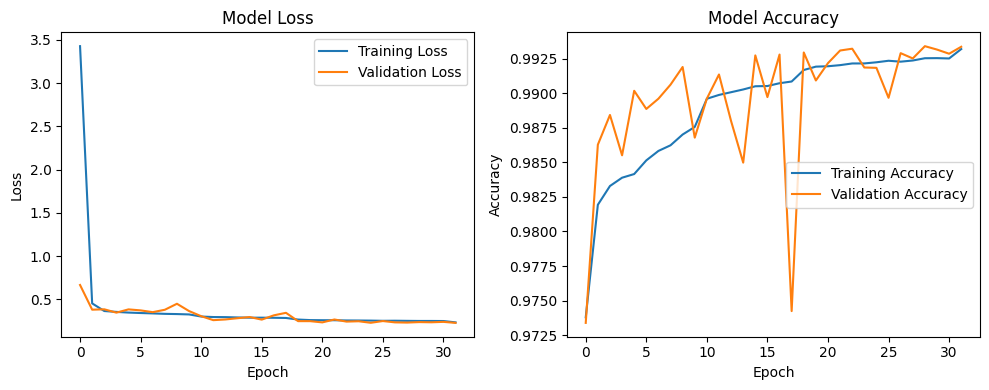

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training history from CSV
result = pd.read_csv('/content/drive/MyDrive/arcade/stenosis/61.42F_seUnet.csv')

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(result['loss'], label='Training Loss')
plt.plot(result['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(result['accuracy'], label='Training Accuracy')
plt.plot(result['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('GRAPHS.png', bbox_inches='tight', dpi=300)
# plt.grid(True)

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


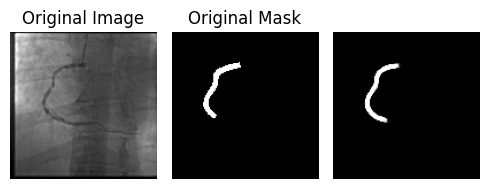

In [18]:

test_images = np.load("/content/drive/MyDrive/arcade/stenosis/preprocessed_original_images/test_images.npy")
test_masks = np.load("/content/drive/MyDrive/arcade/stenosis/preprocessed_original_images/test_masks.npy")



# # Load trained U-Net model with custom loss function
model_path = '/content/drive/MyDrive/arcade/stenosis/61.47F.keras'

# Load your model
model = tf.keras.models.load_model(model_path, custom_objects={'combined_loss': combined_loss})


# Select a single image and mask
index = 3 # Change this index to visualize a different image
image = test_images[index]
true_mask = test_masks[index]

# Generate the predicted mask for the selected image
# Add batch dimension (model.predict expects a batch of images)
predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]

# Function to display the original image, original mask, and predicted mask
def display_single_result(image, true_mask, pred_mask):
    plt.figure(figsize=(5, 3))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # # Original Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze()[:,:,1], cmap='gray')  # Select the stenosis channel (index 1) for display
    plt.title("Original Mask")
    # plt.savefig('mask_98_original.png', bbox_inches='tight', dpi=300)
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze()[:,:,1], cmap='gray')  # Select the stenosis channel (index 1) for display
    # plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('denseUNET_98.png', bbox_inches='tight', dpi=300)

    plt.show()

display_single_result(image, true_mask, predicted_mask)

In [8]:
def dice_score(y_true, y_pred, epsilon=1e-6):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + epsilon) / (np.sum(y_true) + np.sum(y_pred) + epsilon)


In [11]:

model_path = '/content/drive/MyDrive/arcade/stenosis/61.47F.keras'

# Load your model
model = tf.keras.models.load_model(model_path, custom_objects={'combined_loss': combined_loss})

all_images = (os.listdir(test_images_path))

all_dice_image = dict()

for i in all_images:
  img = os.path.join( test_images_path, i )
  img = cv2.imread(img)
  img_resized = cv2.resize(img, (128, 128)) / 255.0
  img_input = np.expand_dims(img_resized, axis=0)
  pred = model.predict(img_input)[0]
  pred_mask = np.argmax(pred, axis=-1).astype(np.uint8)
  mask_path = os.path.join(test_masks_path, 'mask_' + i)
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # Load as grayscale

  # Check if the mask was loaded successfully
  if mask is None:
      print(f"Warning: Could not load mask file: {mask_path}. Skipping.")
      continue

  mask_resized = cv2.resize(mask, (128, 128))
  mask_binary = (mask_resized > 127).astype(np.uint8)
  score = dice_score(mask_binary, pred_mask)
  highest_dice_image = dict()
  highest_dice_image[i] = score
  all_dice_image.update(highest_dice_image)

sorted_desc = sorted(all_dice_image.items(), key=lambda x: x[1], reverse=True)

# Get the top 3
top_3 = dict(sorted_desc[:3])

sorted_asc = sorted(all_dice_image.items(), key=lambda x: x[1], reverse=False)
bottom_3 = dict(sorted_asc[:3])

# Display result
# print("Top 3 images with highest Dice scores:")
print(top_3)
print(bottom_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


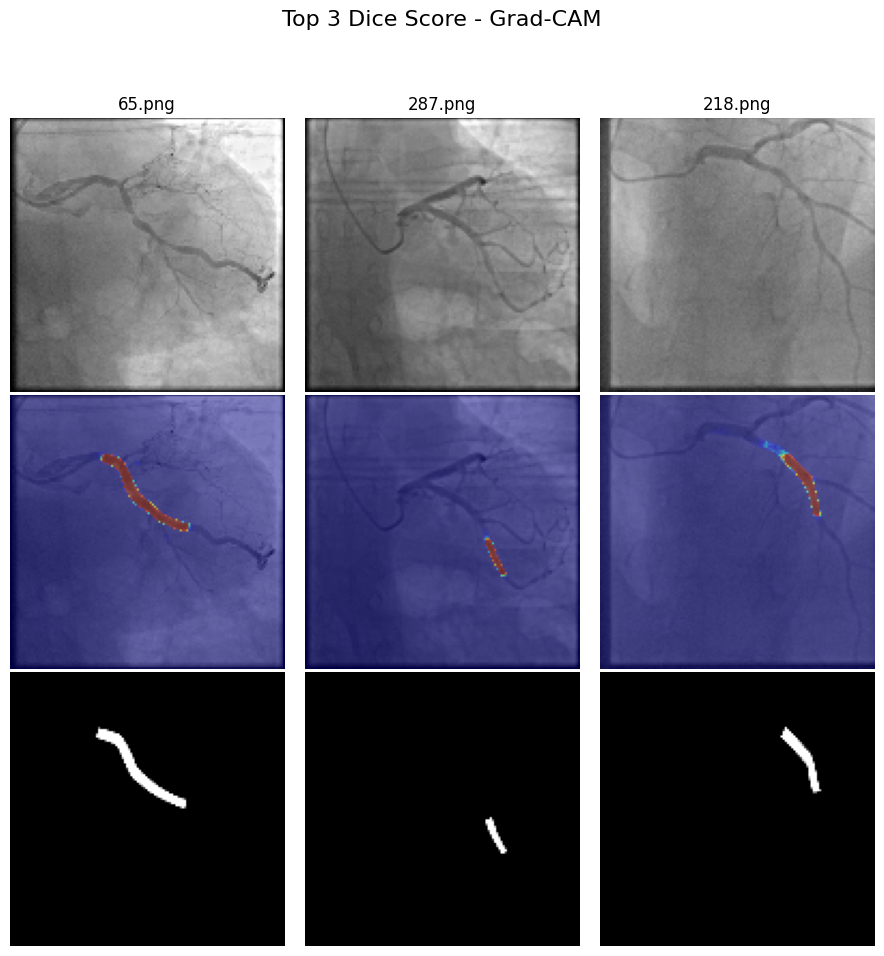

In [12]:
# ---------------- Top 3 Dice Score Images ----------------


# --- Top 3 image names ---
image_indices = ['65.png', '287.png', '218.png']


# --- Grad-CAM helpers ---
def generate_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        loss = tf.reduce_max(predictions)
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (128, 128))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam) if np.max(cam) != 0 else cam
    return cam

def overlay_gradcam_on_image(img, heatmap, alpha=0.5):
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    return cv2.addWeighted(np.uint8(img), 1 - alpha, heatmap_color, alpha, 0)

# --- Visualization ---
fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # 3 columns = 3 images per figure

layer_name = 'conv2d_18'  # Update as needed

for col, img_name in enumerate(image_indices):
    img_path = os.path.join(test_images_path, img_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (128, 128)) / 255.0

    heatmap = generate_gradcam(model, img_resized, layer_name)
    gradcam_img = overlay_gradcam_on_image((img_resized * 255).astype(np.uint8), heatmap)

    mask_path = os.path.join(test_masks_path, 'mask_' + img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_resized = cv2.resize(mask, (128, 128)) if mask is not None else np.zeros((128, 128))

    axes[0, col].imshow(img_resized)
    axes[1, col].imshow(gradcam_img)
    axes[2, col].imshow(mask_resized, cmap='gray')

    for row in range(3):
        axes[row, col].axis('off')
    axes[0, col].set_title(img_name)

axes[0, 0].set_ylabel("Input", fontsize=14)
axes[1, 0].set_ylabel("Grad-CAM", fontsize=14)
axes[2, 0].set_ylabel("Ground Truth", fontsize=14)
plt.subplots_adjust(left=0.01, right=0.99, top=0.93, bottom=0.01,
                    wspace=0.01, hspace=0.01)

plt.suptitle("Grad-CAM Visualization", fontsize=18, y=1.02)
plt.suptitle("Top 3 Dice Score - Grad-CAM", fontsize=16, y=1.05)
# plt.savefig('bad_dice scores', dpi = 500)
plt.show()


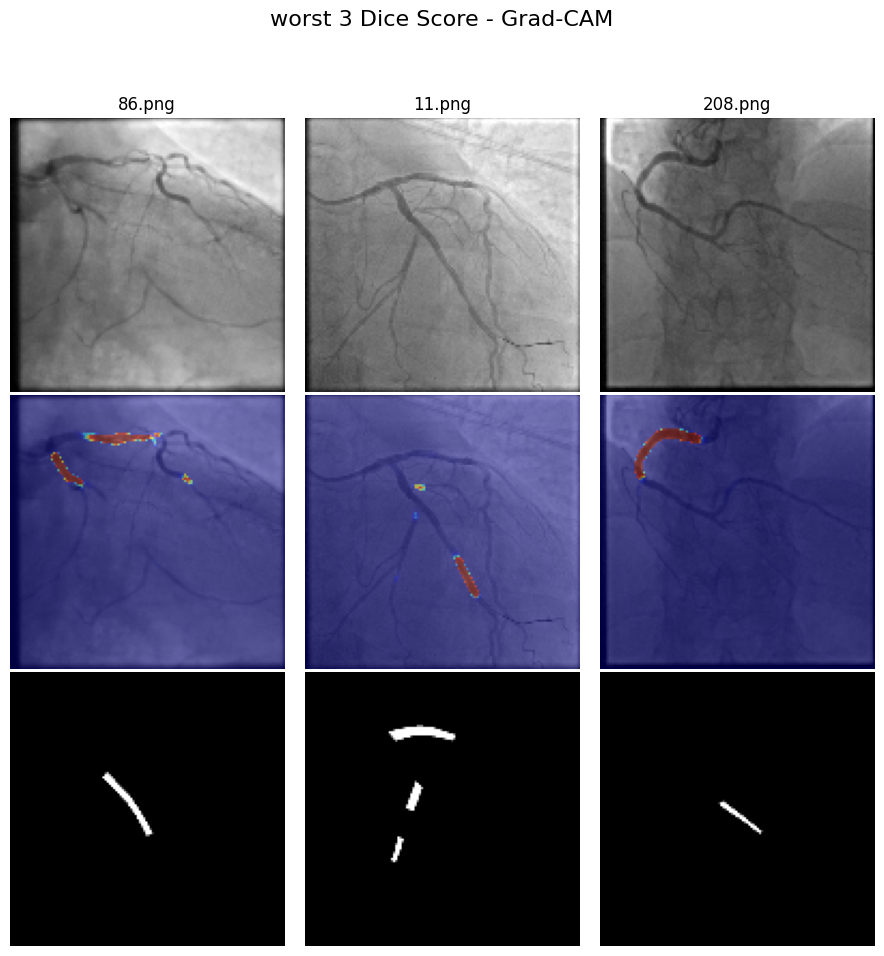

In [14]:


# --- worst predicted 3 image names ---
image_indices = ['86.png', '11.png', '208.png']


# --- Grad-CAM helpers ---
def generate_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        loss = tf.reduce_max(predictions)
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (128, 128))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam) if np.max(cam) != 0 else cam
    return cam

def overlay_gradcam_on_image(img, heatmap, alpha=0.5):
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    return cv2.addWeighted(np.uint8(img), 1 - alpha, heatmap_color, alpha, 0)

# --- Visualization ---
fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # 3 columns = 3 images per figure

layer_name = 'conv2d_18'  # Update as needed

for col, img_name in enumerate(image_indices):
    img_path = os.path.join(test_images_path, img_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (128, 128)) / 255.0

    heatmap = generate_gradcam(model, img_resized, layer_name)
    gradcam_img = overlay_gradcam_on_image((img_resized * 255).astype(np.uint8), heatmap)

    mask_path = os.path.join(test_masks_path, 'mask_' + img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_resized = cv2.resize(mask, (128, 128)) if mask is not None else np.zeros((128, 128))

    axes[0, col].imshow(img_resized)
    axes[1, col].imshow(gradcam_img)
    axes[2, col].imshow(mask_resized, cmap='gray')

    for row in range(3):
        axes[row, col].axis('off')
    axes[0, col].set_title(img_name)

axes[0, 0].set_ylabel("Input", fontsize=14)
axes[1, 0].set_ylabel("Grad-CAM", fontsize=14)
axes[2, 0].set_ylabel("Ground Truth", fontsize=14)
plt.subplots_adjust(left=0.01, right=0.99, top=0.93, bottom=0.01,
                    wspace=0.01, hspace=0.01)

plt.suptitle("Grad-CAM Visualization", fontsize=18, y=1.02)
plt.suptitle("worst 3 Dice Score - Grad-CAM", fontsize=16, y=1.05)
# plt.savefig('bad_dice scores', dpi = 500)
plt.show()
